In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [14]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 10
nu = .001
dt = .0001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

In [3]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

In [4]:
def pressure_poisson(p, dx, dy, b, nt):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] ##dp/dy = 0 at x = 2
        p[0, :] = p[1, :]  ##dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]    ##dp/dx = 0 at x = 0
        if nt%100 == 0:
            p[-1, 10:31] = 100        ##p = 10 at y = 2, nt = 0, every 100 time steps
            p[-1, :10] = 0
            p[-1, 30:] = 0
        else:
            p[-1, :] = 0        ##p = 0 at y = 2 all other time steps
        
    return p

In [33]:
def ink_channel_flow(nt, u, v, dt, dx, dy, p, ptime, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, n)
        pt[n] = p.copy()
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :] = 0
        u[:, 0] = u[:, 1]
        u[:, -1] = u[:, -2]
        u[-1, :] = 0    
        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
        
        
    return u, v, p, pt

In [34]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
pt = numpy.ndarray((nt,ny,nx))
u, v, p, pt = ink_channel_flow(nt, u, v, dt, dx, dy, p, p, rho, nu)

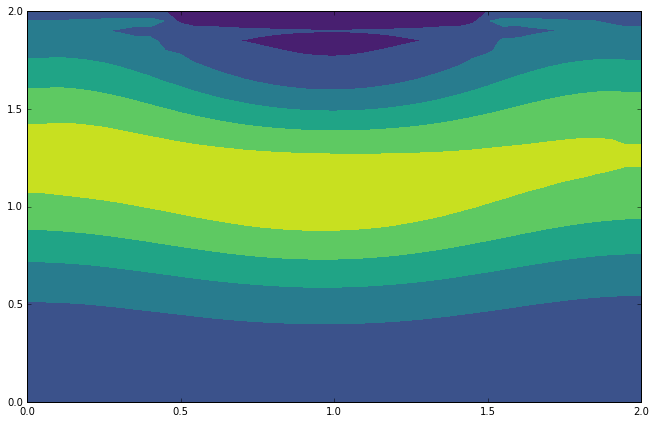

In [35]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, pt[4], cmap=cm.viridis) 

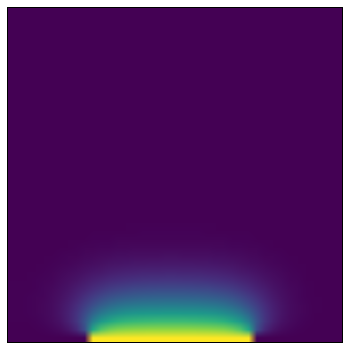

In [36]:
fig = pyplot.figure(figsize=(8,6))
pyplot.xticks([]), pyplot.yticks([]);
im = pyplot.imshow(pt[0], cmap=cm.viridis)

In [18]:
def init():
    im.set_data(numpy.zeros((ny,nx)))
    return im,
def animate(data):
    im.set_array(data)
    return im,

In [37]:
anim = animation.FuncAnimation(fig, animate, frames=pt, interval=75)

In [38]:
HTML(anim.to_html5_video())

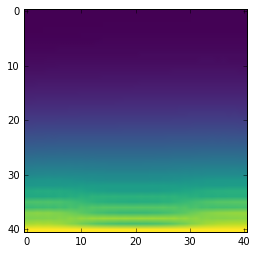

In [43]:
pyplot.imshow(pt[40],cmap=cm.viridis)

In [32]:
pt[499].max()

2.537780671019441